# Capstone 2024 - Table Recognition Work

Dataset:
[PubTables-1m](https://huggingface.co/datasets/bsmock/pubtables-1m)

Model: 
[YoloV11](https://docs.ultralytics.com/models/yolo11/)

In [1]:
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
!wget https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Images_Val.tar.gz

--2024-10-16 07:52:56--  https://huggingface.co/datasets/bsmock/pubtables-1m/resolve/main/PubTables-1M-Structure_Annotations_Val.tar.gz
Resolving huggingface.co (huggingface.co)... 18.160.143.99, 18.160.143.76, 18.160.143.32, ...
Connecting to huggingface.co (huggingface.co)|18.160.143.99|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/36/c0/36c021133128a16f57db86f4cb105c85b76fb8fb4968b96642a02b5140872630/6b8c4b512e24e1040fa0829935ab9c2d13fc0015f7315cc8f13ef82a8bc95ca4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27PubTables-1M-Structure_Annotations_Val.tar.gz%3B+filename%3D%22PubTables-1M-Structure_Annotations_Val.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1729324376&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTMyNDM3Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zNi9jMC8zNmMwMjExMzMxMjhhMTZmNTdkYjg2ZjRjYjEwNWM4NWI3NmZiOGZiNDk2OGI5NjY

In [2]:
!mkdir ./data
!mkdir ./data/PubTables-1M-Structure_Images_Val
!mkdir ./data/PubTables-1M-Structure_Annotations_Val
!tar -xf PubTables-1M-Structure_Images_Val.tar.gz -C ./data/PubTables-1M-Structure_Images_Val
!tar -xf PubTables-1M-Structure_Annotations_Val.tar.gz -C ./data/PubTables-1M-Structure_Annotations_Val

# Create YOLO Dataset

In [3]:
import os
import yaml
import shutil
import cv2
import random
import colorsys

import xml.etree.ElementTree as ET

from glob import glob
from PIL import Image

import matplotlib.pyplot as plt

In [4]:
classes = [
#     'table column',
    'table row',
#     'table spanning cell',
#     'table text cell'
]

def convert_coordinates(size, box):
    dw, dh = 1.0/size[0], 1.0/size[1]
    xmin, ymin, xmax, ymax = box
    w, h = xmax - xmin, ymax - ymin
    x_center, y_center = xmin + w/2, ymin + h/2
    return (x_center * dw, y_center * dh, w * dw, h * dh)

def convert_xml_to_yolo_and_copy_image(xml_file_path, dest_labels_dir, source_images_dir, dest_images_dir):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    filename = root.find('filename').text
    image_path = os.path.join(source_images_dir, filename)
#     print(image_path)
    # Read image dimensions using PIL
    with Image.open(image_path) as img:
        width, height = img.size

    output_filename = os.path.splitext(filename)[0] + '.txt'
    with open(os.path.join(dest_labels_dir, output_filename), 'w') as out_file:
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue

            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                 float(xmlbox.find('xmax').text), float(xmlbox.find('ymax').text))
            bb = convert_coordinates((width, height), b)
            out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")
    
    # Copy corresponding image to train directory
    base_name = os.path.splitext(os.path.basename(xml_file_path))[0]
    for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_file = os.path.join(data_images_dir, base_name + ext)
        if os.path.exists(image_file):
#             print("Copied", image_file, dest_images_dir)
            shutil.copy(image_file, dest_images_dir)
            break
    return

In [5]:
def create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples=0, dataset_split_ratio = 0.8):

    xml_files = glob(os.path.join(data_labels_dir, '*.xml'))

    if number_of_samples:
        xml_files = xml_files[:number_of_samples]
    # Calculate the split index
    split_index = int(len(xml_files) * 0.8)  # Assuming 80% train, 20% val split

    # Split the files
    train_xml_files = xml_files[:split_index]
    val_xml_files = xml_files[split_index:]

    # Process train files
    for xml_file_path in train_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, train_labels_dir, data_images_dir, train_images_dir)

    # Process validation files
    for xml_file_path in val_xml_files:
        convert_xml_to_yolo_and_copy_image(xml_file_path, val_labels_dir, data_images_dir, val_images_dir)

def create_dataset_yaml(dataset_dir, yaml_path):
  # Create the dataset structure
  dataset = {
      'path': os.path.abspath(dataset_dir),
      'train': 'train',  # Assuming all data is for training
      'val': 'val',    # Using same data for validation
    #   'test': 'train',   # Using same data for testing
      'names': {i: name for i, name in enumerate(classes)},
      'nc': len(classes)
  }

  # Write the YAML file
  with open(yaml_path, 'w') as file:
      yaml.dump(dataset, file, default_flow_style=False)

  print(f"Dataset YAML file created at: {yaml_path}")

In [6]:
data_dir = "/kaggle/working/data"
data_images_dir = "/kaggle/working/data/PubTables-1M-Structure_Images_Val"
data_labels_dir = "/kaggle/working/data/PubTables-1M-Structure_Annotations_Val"

dataset_dir = "/kaggle/working/dataset"
train_images_dir = os.path.join(dataset_dir, "train", "images")
train_labels_dir = os.path.join(dataset_dir, "train", "labels")
val_images_dir = os.path.join(dataset_dir, "val", "images")
val_labels_dir = os.path.join(dataset_dir, "val", "labels")

dataset_yaml_path = "/kaggle/working/dataset/dataset.yaml"

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

number_of_samples = 10000
dataset_split_ratio = 0.8

create_dataset(
    data_images_dir, data_labels_dir, 
    train_images_dir, train_labels_dir,
    val_images_dir, val_labels_dir,
    number_of_samples,
    dataset_split_ratio
)
create_dataset_yaml(dataset_dir, dataset_yaml_path)

Dataset YAML file created at: /kaggle/working/dataset/dataset.yaml


In [7]:
# !rm -rf "/kaggle/working/dataset"

# Data sample visualization

34 34 447 50
34 50 447 66
34 66 447 79
34 79 447 92
34 92 447 113


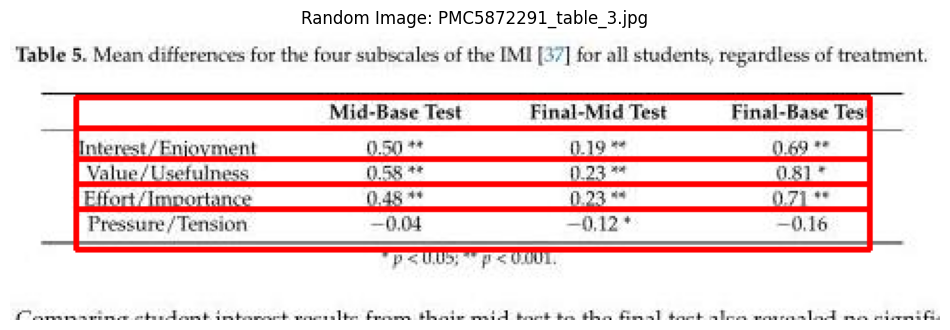

In [8]:
# Load the dataset configuration
with open(dataset_yaml_path, 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')
# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the corresponding label file
label_path = os.path.join(dataset_path, image_set, 'labels', random_image.rsplit('.', 1)[0] + '.txt')

# Read and parse the label file
with open(label_path, 'r') as file:
    labels = file.readlines()

# Get image dimensions
height, width, _ = image.shape

# Function to generate distinct colors
def generate_colors(n):
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    return list(map(lambda x: tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x)), hsv_tuples))

# Generate a color for each class
colors = generate_colors(len(class_names))

# Draw bounding boxes and labels
for label in labels:
    class_id, x_center, y_center, box_width, box_height = map(float, label.strip().split())

    # Convert YOLO format to pixel coordinates
    x1 = int((x_center - box_width/2) * width)
    y1 = int((y_center - box_height/2) * height)
    x2 = int((x_center + box_width/2) * width)
    y2 = int((y_center + box_height/2) * height)

    # Get color for this class
    color = colors[int(class_id)]

    # Draw bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    print(x1, y1, x2, y2)

    # Add label
    class_name = class_names[int(class_id)]
    # cv2.putText(image, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.title(f"Random Image: {random_image}")
plt.show()

In [9]:
labels

['0 0.4978413223140496 0.2831016666666667 0.8529719008264462 0.10619666666666666\n',
 '0 0.4978413223140496 0.388973 0.8529719008264462 0.10554599999999999\n',
 '0 0.4978413223140496 0.48533266666666675 0.8529719008264462 0.0871733333333334\n',
 '0 0.4978413223140496 0.5725076666666666 0.8529719008264462 0.08717666666666664\n',
 '0 0.4978413223140496 0.6851183333333334 0.8529719008264462 0.13804466666666665\n']

In [10]:
!rm -rf "/kaggle/working/data"
!rm -rf "/kaggle/working/*.tar"
!rm -rf "/kaggle/working/*.gz"

# Model training

In [11]:
!pip install --no-cache-dir ultralytics
!pip install -U ipywidgets
os.environ['WANDB_DISABLED'] = 'true'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 231.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [12]:
from ultralytics import YOLO
model = YOLO("yolo11m.pt")
model.train(
    data=dataset_yaml_path,
    epochs=100,
    device="cuda",
    translate=0.2,
    scale=0.2,
    flipud=0.0,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 38.8M/38.8M [00:00<00:00, 252MB/s]


Ultralytics 8.3.13 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.18.3
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLO11n...


100%|██████████| 5.35M/5.35M [00:00<00:00, 64.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 8000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8000/8000 [00:07<00:00, 1018.85it/s]


train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/val/labels... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:02<00:00, 865.48it/s]


val: New cache created: /kaggle/working/dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.73G      1.878      1.231       1.55        578        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:20<00:00,  3.07it/s]


                   all       2000      26255      0.786      0.872      0.883      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      8.52G      1.217     0.8244      1.064        580        640: 100%|██████████| 500/500 [04:47<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.842      0.838      0.887      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.61G      1.183     0.8016     0.9887        481        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255       0.71      0.756      0.773      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.73G      1.066     0.7095     0.9556        421        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.906      0.893      0.933      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.56G     0.9349      0.623     0.9233        459        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


                   all       2000      26255      0.911      0.906      0.937      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.62G     0.8632     0.5782     0.9114        527        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.886      0.832      0.912      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.59G      0.805     0.5388     0.8991        500        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.942      0.926      0.964      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.57G     0.7667     0.5147     0.8883        463        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.954      0.932      0.961      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.54G     0.7224      0.485     0.8815        524        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.952      0.922      0.963      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.57G     0.7033     0.4743     0.8795        588        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.951      0.927      0.965      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      8.51G     0.6818     0.4593     0.8749        421        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.959      0.932      0.967      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      8.66G     0.6579      0.446      0.871        462        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.965      0.941      0.969      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      8.55G     0.6477     0.4378     0.8714        591        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255       0.97      0.946      0.973      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      8.56G     0.6236     0.4242     0.8649        563        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.966      0.939      0.974      0.802

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      8.56G      0.615      0.417     0.8637        552        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.952       0.93      0.966       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.58G      0.603     0.4096     0.8631        481        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.975      0.942      0.973      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.73G     0.5943     0.4027     0.8574        490        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.943      0.933      0.967      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      8.58G     0.5871     0.3981     0.8577        500        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


                   all       2000      26255       0.97       0.94      0.972      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.64G     0.5765     0.3902     0.8582        531        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.971      0.942      0.973      0.808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      8.52G     0.5649     0.3837     0.8549        480        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.972      0.945      0.975      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      8.57G     0.5553     0.3784     0.8542        485        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.972      0.946      0.976      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       8.6G     0.5508     0.3755     0.8509        539        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.974      0.944      0.974      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      8.73G     0.5407     0.3685     0.8498        551        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


                   all       2000      26255      0.978      0.947      0.974      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       8.6G     0.5338     0.3657     0.8492        506        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.977      0.946      0.977      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      8.57G     0.5335     0.3624     0.8483        477        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.979       0.95      0.976       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      8.56G     0.5259     0.3568     0.8456        566        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.979      0.949      0.977      0.823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      8.56G     0.5239     0.3568     0.8496        525        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255       0.98      0.947      0.978       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      8.52G     0.5179     0.3519      0.846        445        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.977      0.945      0.979      0.821

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      8.51G     0.5103     0.3496     0.8433        429        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.975      0.951      0.977      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      8.64G     0.5047     0.3435     0.8455        436        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.976      0.943      0.976      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.61G     0.5012     0.3432     0.8432        468        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.978      0.947      0.979      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      8.55G     0.4982      0.341     0.8407        443        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.982      0.953      0.979      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      8.56G     0.4933     0.3362     0.8411        402        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.983      0.952      0.978      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      8.58G       0.49      0.333     0.8387        443        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.978      0.955       0.98      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      8.59G     0.4846     0.3313     0.8404        584        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.981      0.948      0.979      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      8.56G     0.4801     0.3271     0.8397        492        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.979      0.949      0.978       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      8.54G     0.4769      0.327      0.838        485        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.972      0.949      0.977      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      8.53G     0.4747     0.3245      0.842        523        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.978      0.944      0.979      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      8.55G     0.4708     0.3219     0.8373        389        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.30it/s]

                   all       2000      26255      0.983      0.954       0.98      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      8.63G     0.4713     0.3242     0.8385        513        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255       0.98      0.953      0.978      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      8.57G     0.4601     0.3148     0.8377        480        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.982      0.952       0.98      0.852

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      8.57G     0.4607     0.3177     0.8381        435        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.981      0.953      0.979       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.54G     0.4558     0.3077     0.8348        475        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.982      0.954      0.979       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      8.58G     0.4547     0.3118     0.8342        339        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.983      0.952       0.98      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.68G     0.4496     0.3067     0.8312        545        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.983      0.955       0.98      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.53G     0.4441     0.3038     0.8349        532        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.983      0.953      0.981      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      8.57G     0.4429     0.3022     0.8317        579        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.984      0.953      0.981      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      8.58G     0.4411     0.3023     0.8348        543        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.984      0.952      0.982      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.59G     0.4349     0.2974     0.8321        456        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.984      0.954      0.981      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.57G     0.4353     0.2974      0.831        431        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]


                   all       2000      26255      0.985      0.954      0.982      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.52G     0.4307     0.2946     0.8335        414        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.983      0.956      0.982      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      8.52G     0.4288      0.295     0.8307        507        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.986      0.956      0.981      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      8.54G     0.4247     0.2906     0.8289        468        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.982      0.952      0.982      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      8.53G       0.42     0.2871     0.8289        493        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.982      0.955      0.981      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.58G     0.4201     0.2873      0.831        468        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.984      0.956      0.981      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      8.53G     0.4168     0.2845     0.8288        421        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.984      0.955      0.981      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      8.56G     0.4177     0.2847     0.8268        589        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.984      0.953      0.982       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       8.6G     0.4091     0.2799     0.8281        549        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.984      0.953      0.981       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      8.54G     0.4071     0.2779     0.8281        486        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.985      0.956      0.981       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.58G     0.4091     0.2824     0.8298        622        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.983      0.955      0.981      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      8.54G     0.4048     0.2768     0.8267        478        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.984      0.955      0.981       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      8.54G     0.4008     0.2745     0.8259        369        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]


                   all       2000      26255      0.984      0.955      0.981      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      8.52G        0.4     0.2752     0.8269        513        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.984      0.954      0.982       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.62G     0.3961     0.2716      0.825        452        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.984      0.953      0.981       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      8.56G      0.393     0.2677      0.825        566        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.985      0.953      0.981       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      8.61G     0.3893     0.2662     0.8251        634        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all       2000      26255      0.983      0.954      0.981       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.55G     0.3859      0.263     0.8245        415        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.982      0.952       0.98      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      8.56G     0.3818     0.2621     0.8251        497        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


                   all       2000      26255      0.982      0.954      0.981      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       8.5G     0.3839     0.2612     0.8256        411        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.983      0.952       0.98      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      8.57G      0.379     0.2568     0.8243        472        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


                   all       2000      26255      0.984      0.952       0.98      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      8.65G     0.3784     0.2556     0.8238        515        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.983      0.954      0.981      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.57G     0.3764     0.2547     0.8239        546        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]

                   all       2000      26255      0.983      0.953      0.981      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      8.74G     0.3729     0.2548     0.8234        400        640: 100%|██████████| 500/500 [04:44<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]

                   all       2000      26255      0.982      0.953      0.979      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      8.57G     0.3693     0.2514     0.8226        404        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:20<00:00,  3.14it/s]

                   all       2000      26255      0.983      0.953      0.981      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      8.62G     0.3722     0.2543     0.8222        564        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.982      0.953      0.979      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       8.7G     0.3689     0.2496      0.823        470        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


                   all       2000      26255      0.984      0.953       0.98      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      8.59G     0.3651     0.2466     0.8214        547        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.29it/s]

                   all       2000      26255      0.983      0.953       0.98      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      8.62G     0.3607     0.2437     0.8228        482        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


                   all       2000      26255      0.984      0.954      0.981      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      8.62G     0.3605     0.2437     0.8213        411        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.986      0.955      0.981      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      8.62G     0.3585     0.2422     0.8194        535        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.985      0.955       0.98      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      8.66G      0.354     0.2391     0.8215        520        640: 100%|██████████| 500/500 [04:45<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.985      0.955      0.981      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      8.53G     0.3502     0.2363     0.8201        532        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.985      0.955      0.981      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      8.61G     0.3485     0.2351      0.822        477        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.984      0.954      0.981      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      8.55G     0.3495      0.235     0.8201        444        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.985      0.953      0.982      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      8.57G     0.3489     0.2316     0.8206        518        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.985      0.953      0.981      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      8.51G     0.3418     0.2288     0.8184        483        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.985      0.954      0.981      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      8.59G     0.3393     0.2271     0.8189        530        640: 100%|██████████| 500/500 [04:44<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.985      0.955      0.981      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      8.53G     0.3368     0.2249     0.8202        548        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.984      0.954      0.982      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      8.58G     0.3357     0.2237     0.8184        509        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.985      0.954      0.982      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      8.62G     0.3306     0.2218     0.8197        464        640: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.985      0.954      0.982      0.866


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      8.49G     0.5533     0.2912     0.7462        194        640: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


                   all       2000      26255      0.985      0.954      0.982      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      8.53G     0.5481     0.2895     0.7464        164        640: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.984      0.956      0.982      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       8.5G     0.5439     0.2843     0.7456        168        640: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.984      0.956      0.983      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      8.56G     0.5434     0.2833     0.7449        195        640: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.983      0.956      0.983      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      8.54G      0.537     0.2816     0.7489        174        640: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]

                   all       2000      26255      0.984      0.956      0.983      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      8.53G     0.5342      0.278     0.7445        195        640: 100%|██████████| 500/500 [04:41<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


                   all       2000      26255      0.984      0.955      0.983      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      8.53G     0.5279     0.2733     0.7439        333        640: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]

                   all       2000      26255      0.983      0.955      0.983       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       8.6G     0.5275     0.2712      0.743        202        640: 100%|██████████| 500/500 [04:41<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.28it/s]

                   all       2000      26255      0.984      0.955      0.983       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      8.54G     0.5225     0.2707     0.7432        275        640: 100%|██████████| 500/500 [04:41<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.27it/s]

                   all       2000      26255      0.984      0.955      0.984       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      8.51G     0.5198     0.2676     0.7427        240        640: 100%|██████████| 500/500 [04:41<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.25it/s]

                   all       2000      26255      0.984      0.955      0.984      0.881



100 epochs completed in 8.467 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.13 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 303 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


                   all       2000      26255      0.985      0.955      0.984      0.881
Speed: 0.1ms preprocess, 5.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▁▁
wandb:                  lr/pg1 ███▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▃▁▆▆▆▇▇▇▇▇▇█▇▇█▇▇███████████████████████
wandb:     metrics/mAP50-95(B) ▁▅▄▆▅▆▆▆▇▇▇▇▇▇█▇▇▇██████████████████████
wandb:    metrics/precision(B) ▁▅▅▆▇▇▇▇▇███████████████████████████████
wandb:       metrics/recall(B) ▃▁▁▇▇▇▇▇▇▇██▇▇██████████████████████████
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
wandb:          train/cls_loss █▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
wandb:            val/box_loss █▆▅▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f419244760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model testing


0: 608x640 46 table rows, 58.5ms
Speed: 3.3ms preprocess, 58.5ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


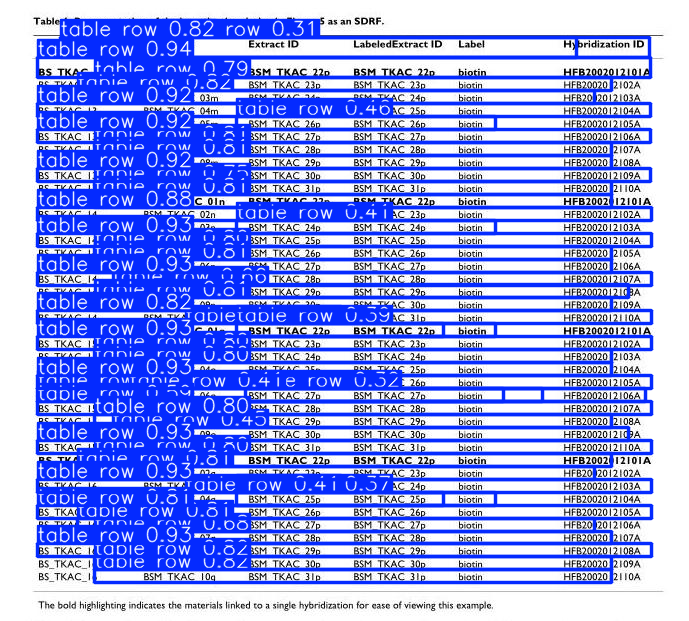

In [13]:
# Load the dataset configuration
with open(r"/kaggle/working/dataset/dataset.yaml", 'r') as file:
    dataset_config = yaml.safe_load(file)

# Get the dataset path and class names
dataset_path = dataset_config['path']
class_names = dataset_config['names']

# Choose a random set (train or val)
image_set = random.choice(['train', 'val'])
images_path = os.path.join(dataset_path, image_set, 'images')

# Get a list of all image files
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image
random_image = random.choice(image_files)
image_path = os.path.join(images_path, random_image)

# Run batched inference on a list of images
results = model([image_path])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

# Model export

In [14]:
model.export(format="onnx", dynamic=True)

Ultralytics 8.3.13 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.6 MB)
requirements: Ultralytics requirements ['onnxslim==0.1.34', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 235.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 191.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 233.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 18.7s, installed 2 packages: ['onnxslim==0.1.34', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.34...
ONNX: export success ✅ 46.8s, saved as 'runs/detect/train/weights/best.onnx

'runs/detect/train/weights/best.onnx'